from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot

model = VGG16()
model.summary()

for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)


filters, biases = model.layers[2].get_weights()
print(model.layers[1].name)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)


n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(f[:, :, j], cmap = 'gray')
        ix += 1
        
pyplot.show()

from matplotlib import image as mp_image
import matplotlib.pyplot as plt
from tensorflow import keras

url = 'https://raw.githubusercontent.com/kotech1/computervision/master/img/2011_002300-dog.jpg'
sample_image_path = keras.utils.get_file(
    '2011_002300-dog.jpg', url)
image = mp_image.imread(sample_image_path)
plt.imshow(image)
plt.show()



from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

model1 = VGG16()
layer = 2
model = Model(inputs=model1.inputs, outputs=model1.layers[layer].output)
img = load_img(sample_image_path, target_size = (224,224))
img = img_to_array(img)
img = expand_dims(img, axis = 0)
img = preprocess_input(img)
feature_maps = model.predict(img)

square = 8
ix = 1
offset = 0
pyplot.figure(figsize = (8, 10))
for _ in range(square):
    for _ in range(square):
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        img = feature_maps[0, :, :, ix-1+offset]
        import numpy as np
        img = np.clip(img, -1000, 1000)
        pyplot.imshow(img)
        ix += 1
pyplot.show()




# Neural Style Transfer

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import VGG19

In [3]:
def limit_gpu(gb):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    num_gpu = 1
    memory_limit = 1024 * gb
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(gpus[num_gpu - 1], [
                tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
            print("Use {} GPU limited {}MB memory".format(num_gpu, memory_limit))
        except RuntimeError as e:
            print(e)

    else:
        print('GPU is not available')
limit_gpu(0.25)

GPU is not available


In [4]:
total_variation_weight = 5e-7
style_weight = 1e-5
content_weight = 2.5e-8

C: base_image

S: style_reference_image

G: combined_image

In [5]:
base_image_path = keras.utils.get_file("london-bridge.jpg", "https://pixy.org/src/0/thumbs350/123.jpg")
style_reference_image_path = keras.utils.get_file( "franz-marc.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg/691px-Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg")
result_prefix = 'london_generated'

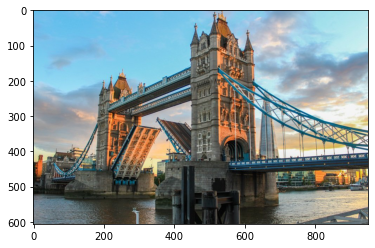

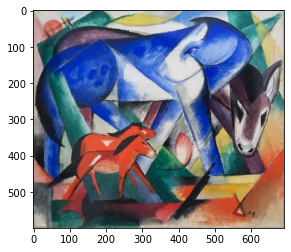

In [6]:
from matplotlib import image as mp_image
import matplotlib.pyplot as plt
img = mp_image.imread(base_image_path)
plt.imshow(img)
plt.show()

img = mp_image.imread(style_reference_image_path)
plt.imshow(img)
plt.show()

In [7]:
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width*img_nrows/height)

In [8]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size = (img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [9]:
def gram_matrix(x):
    x = tf.transpose(x, (2,0,1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

### Style Loss

In [10]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [11]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [12]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

### VGG19

In [13]:
model = VGG19(weights = 'imagenet', include_top = False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs = outputs_dict)

In [14]:
# style loss에 사용할 레이어
#style_layer_names = [
#    "block1_conv1",
#    "block2_conv1",
#    "block3_conv1",
#    "block4_conv1",
#    "block5_conv1",
#]



style_layer_names = [
    "block1_conv2",
    "block2_conv2",
    "block3_conv2",
    "block4_conv2",
    "block5_conv2",
]

In [15]:
content_layer_name = "block5_conv2"


In [16]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # loss 초기화
    loss = tf.zeros(shape=())

    # content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    c_loss = content_weight * content_loss(
        base_image_features, combination_features
    )
    s_loss = tf.zeros(shape=())
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        s_loss += (style_weight / len(style_layer_names)) * sl
    
    # total variation loss
    t_loss = total_variation_weight * total_variation_loss(combination_image)
    loss = c_loss+s_loss+t_loss 
    return loss, c_loss, s_loss, t_loss


In [17]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, t_loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads, c_loss, s_loss, t_loss


In [18]:


optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96f
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000

for i in range(1, iterations + 1):
    loss, grads, c_loss, s_loss, t_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0 or i == 1:
        print("Iteration %d: loss=%.2f, content_loss=%.2f, style_loss=%.2f, total_variation_loss=%.2f" %
               (i, loss, c_loss, s_loss, t_loss))
    if i % 100 == 0:
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 1: loss=169365.17, content_loss=0.00, style_loss=166242.89, total_variation_loss=3122.28
Iteration 10: loss=69651.02, content_loss=32.91, style_loss=67247.49, total_variation_loss=2370.62
Iteration 20: loss=35834.21, content_loss=42.86, style_loss=33847.87, total_variation_loss=1943.48
Iteration 30: loss=26387.15, content_loss=45.28, style_loss=24659.26, total_variation_loss=1682.61
Iteration 40: loss=20525.54, content_loss=46.16, style_loss=18953.97, total_variation_loss=1525.40
Iteration 50: loss=17379.90, content_loss=49.14, style_loss=15906.09, total_variation_loss=1424.67
Iteration 60: loss=14170.36, content_loss=48.32, style_loss=12801.30, total_variation_loss=1320.74
Iteration 70: loss=11865.38, content_loss=50.16, style_loss=10566.28, total_variation_loss=1248.94
Iteration 80: loss=10461.02, content_loss=50.89, style_loss=9208.59, total_variation_loss=1201.54
Iteration 90: loss=8496.62, content_loss=51.05, style_loss=7305.76, total_variation_loss=1139.81
Iteration 100

Iteration 850: loss=1467.90, content_loss=55.35, style_loss=738.47, total_variation_loss=674.08
Iteration 860: loss=1463.76, content_loss=55.32, style_loss=735.55, total_variation_loss=672.89
Iteration 870: loss=1480.50, content_loss=55.20, style_loss=753.85, total_variation_loss=671.45
Iteration 880: loss=1556.10, content_loss=55.11, style_loss=830.50, total_variation_loss=670.49
Iteration 890: loss=1480.70, content_loss=55.34, style_loss=754.42, total_variation_loss=670.94
Iteration 900: loss=1439.09, content_loss=55.42, style_loss=713.46, total_variation_loss=670.22
Iteration 910: loss=1432.38, content_loss=55.42, style_loss=707.67, total_variation_loss=669.29
Iteration 920: loss=1427.86, content_loss=55.43, style_loss=703.94, total_variation_loss=668.49
Iteration 930: loss=1427.29, content_loss=55.45, style_loss=704.04, total_variation_loss=667.80
Iteration 940: loss=1426.96, content_loss=55.43, style_loss=704.44, total_variation_loss=667.09
Iteration 950: loss=1433.00, content_los

Iteration 1700: loss=1207.17, content_loss=55.52, style_loss=517.80, total_variation_loss=633.85
Iteration 1710: loss=1205.59, content_loss=55.52, style_loss=516.48, total_variation_loss=633.60
Iteration 1720: loss=1204.06, content_loss=55.52, style_loss=515.19, total_variation_loss=633.35
Iteration 1730: loss=1202.53, content_loss=55.52, style_loss=513.91, total_variation_loss=633.10
Iteration 1740: loss=1201.01, content_loss=55.51, style_loss=512.64, total_variation_loss=632.86
Iteration 1750: loss=1199.51, content_loss=55.51, style_loss=511.37, total_variation_loss=632.62
Iteration 1760: loss=1197.98, content_loss=55.51, style_loss=510.09, total_variation_loss=632.38
Iteration 1770: loss=1196.49, content_loss=55.51, style_loss=508.83, total_variation_loss=632.14
Iteration 1780: loss=1195.02, content_loss=55.51, style_loss=507.59, total_variation_loss=631.91
Iteration 1790: loss=1193.59, content_loss=55.51, style_loss=506.40, total_variation_loss=631.68
Iteration 1800: loss=1192.16, 

Iteration 2550: loss=1117.89, content_loss=55.45, style_loss=443.48, total_variation_loss=618.97
Iteration 2560: loss=1117.21, content_loss=55.45, style_loss=442.92, total_variation_loss=618.85
Iteration 2570: loss=1116.54, content_loss=55.45, style_loss=442.37, total_variation_loss=618.73
Iteration 2580: loss=1115.87, content_loss=55.45, style_loss=441.82, total_variation_loss=618.61
Iteration 2590: loss=1115.21, content_loss=55.44, style_loss=441.28, total_variation_loss=618.49
Iteration 2600: loss=1114.55, content_loss=55.44, style_loss=440.74, total_variation_loss=618.37
Iteration 2610: loss=1113.90, content_loss=55.44, style_loss=440.20, total_variation_loss=618.26
Iteration 2620: loss=1113.26, content_loss=55.44, style_loss=439.68, total_variation_loss=618.14
Iteration 2630: loss=1112.62, content_loss=55.44, style_loss=439.15, total_variation_loss=618.02
Iteration 2640: loss=1111.98, content_loss=55.44, style_loss=438.63, total_variation_loss=617.91
Iteration 2650: loss=1111.35, 

Iteration 3400: loss=1075.68, content_loss=55.41, style_loss=409.04, total_variation_loss=611.22
Iteration 3410: loss=1075.32, content_loss=55.41, style_loss=408.75, total_variation_loss=611.16
Iteration 3420: loss=1074.97, content_loss=55.41, style_loss=408.47, total_variation_loss=611.09
Iteration 3430: loss=1074.61, content_loss=55.41, style_loss=408.18, total_variation_loss=611.02
Iteration 3440: loss=1074.26, content_loss=55.41, style_loss=407.90, total_variation_loss=610.96
Iteration 3450: loss=1073.92, content_loss=55.41, style_loss=407.62, total_variation_loss=610.89
Iteration 3460: loss=1073.57, content_loss=55.41, style_loss=407.34, total_variation_loss=610.83
Iteration 3470: loss=1073.23, content_loss=55.41, style_loss=407.06, total_variation_loss=610.76
Iteration 3480: loss=1072.88, content_loss=55.41, style_loss=406.78, total_variation_loss=610.70
Iteration 3490: loss=1072.55, content_loss=55.41, style_loss=406.51, total_variation_loss=610.63
Iteration 3500: loss=1072.21, 

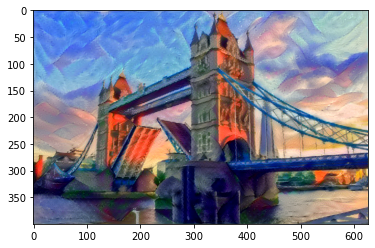

In [26]:
img = mp_image.imread(result_prefix + '_at_iteration_'+'%d.png'%100)
plt.imshow(img)
plt.show()

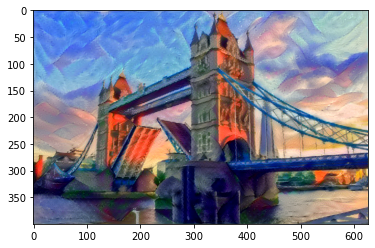

In [24]:
img = mp_image.imread(result_prefix + '_at_iteration_'+'%d.png'%100)
plt.imshow(img)
plt.show()

In [27]:
plt.savefig('fig1.png')

<Figure size 432x288 with 0 Axes>